In [997]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('seaborn-whitegrid')
pd.set_option("display.precision", 5)

In [998]:
# magic to reload modules automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [999]:
ff = pd.read_excel('data/5factors.xlsx')
rt = pd.read_excel('data/north.xlsx' , skiprows=3)
esg = pd.read_excel('data/north31.xlsx', skiprows=3)
print(rt.shape)
print(esg.shape)
print(ff.shape)

(2352, 124)
(12, 739)
(8261, 7)


In [1000]:
pd.set_option('display.max_columns',735) # I want to see all the columns
pd.set_option('display.max_rows',735) 

In [1001]:
ff.rename(columns = {'Unnamed: 0' : 'date'}, inplace=True)
ff['date'] = pd.to_datetime(ff['date'], format='%Y%m%d')
filt = (ff['date'] >= pd.to_datetime('2013-04-03')) & (ff['date'] <= pd.to_datetime('2022-02-28'))
ff = ff[filt]
ff.reset_index(inplace = True, drop = True)

In [1002]:
rt.drop(index=[0,1,2], inplace=True)
rt.reset_index(inplace = True, drop = True) # Drop old index too

In [1003]:
it = rt.copy()
it.to_excel('it.xlsx')

In [1004]:
rt.rename(columns={'Unnamed: 0':'date'},inplace = True) 
xx = ['1COV GY Equity','DTG GY Equity','SINCH SS Equity',
                 'SHL GY Equity','NEL NO Equity','DHER GY Equity',
                 'HFG GY Equity','LIN GY Equity','NETS DC Equity',
                 'DAX Index','OMXS30B Index','OMXC25 Index','OMX Index']
drop_these = []
for i in xx:
    for j in range(1,6):
        drop_these.append(i + '.' + str(j))
drop_these = xx + drop_these
rt.drop(columns=xx, inplace = True)

In [1005]:
rt.columns = rt.columns.str.replace(' GY', ' G')
rt.columns = rt.columns.str.replace(' SS', ' S')
rt.columns = rt.columns.str.replace(' NO', ' N')
rt.columns = rt.columns.str.replace(' DC', ' D')
rt.columns = rt.columns.str.replace(' Equity', '')
rt.columns = rt.columns.str.replace(' ', '_')

In [1006]:
rt['date'] = pd.to_datetime(rt['date'])
#rt.set_index('date',inplace = True) 

In [1007]:
esg.drop(columns=drop_these,inplace = True) 
esg.drop(index=[0,2], inplace=True)
esg.rename(columns={'Unnamed: 0':'Date'},inplace = True) 
esg.reset_index(inplace = True, drop = True) 

In [1008]:
esg.replace({'ESG_DISCLOSURE_SCORE': 'ESG', 'ENVIRON_DISCLOSURE_SCORE': 'E',
             'SOCIAL_DISCLOSURE_SCORE': 'S','GOVNCE_DISCLOSURE_SCORE': 'G',
             'HISTORICAL_MARKET_CAP' : 'HMCAP', 'CUR_MKT_CAP': 'MCAP'}, inplace=True)

In [1009]:
asg = esg.iloc[1] + ' ' + esg.iloc[0]
esg = esg.append(asg, ignore_index=True)
esg.loc[10,'Date'] = 'date'
nnn = esg.loc[10]
esg.rename(columns=nnn, inplace=True)
esg.drop(index=[0,1,10], inplace=True)
esg.reset_index(inplace = True, drop = True)

In [1010]:
esg.columns = esg.columns.str.replace(' GY', ' G')
esg.columns = esg.columns.str.replace(' SS', ' S')
esg.columns = esg.columns.str.replace(' NO', ' N')
esg.columns = esg.columns.str.replace(' DC', ' D')
esg.columns = esg.columns.str.replace(' Equity', '')
esg.columns = esg.columns.str.replace(' ', '_')
esg.set_index('date', inplace=True)

In [1011]:
esg_esg = esg.loc[:,'ADS_G_ESG':'VWS_D_ESG']
esg_esg.columns = esg_esg.columns.str.replace('_ESG', '')

In [1012]:
for i in rt.columns[1:]:
    rt.loc[:,i] = rt.loc[:,i].pct_change(1)*100
rt.drop(index=[0], inplace=True)

In [1013]:
nyind = []
for i in esg_esg.index:
    nyind.append(str(i)+ '_esg')
esg_esg.index = nyind

In [1014]:
rtt = pd.concat([rt, esg_esg])

In [1015]:
#rtt.drop(columns='EVO_S', inplace=True)
#rt.drop(columns='EVO_S', inplace=True)

In [1016]:
filt = (rtt['date'] >= pd.to_datetime('2013-01-01')) & (rtt['date'] <= pd.to_datetime('2013-12-31')) 
thirteen = rtt[filt]
thirteen = pd.concat([thirteen, esg_esg])
thirteen = thirteen.replace(0, np.nan)
thirteen.dropna(how='all', axis='columns', thresh=150, inplace=True)
thirteen = thirteen.replace(np.nan, 0)
print(thirteen.shape)

(203, 103)


In [1017]:
#  2013
q_l = thirteen.loc[thirteen.index[-8], 'ADS_G' : 'VWS_D'].quantile(q=0.33)
q_h = thirteen.loc[thirteen.index[-8], 'ADS_G' : 'VWS_D'].quantile(q=0.67)
I = (thirteen.loc['2014_esg', 'ADS_G':'VWS_D'] <= q_l)
Ii = (thirteen.loc['2014_esg', 'ADS_G':'VWS_D'] > q_l) & (thirteen.loc['2014_esg', 'ADS_G':'VWS_D'] <= q_h)
Iii = (thirteen.loc['2014_esg', 'ADS_G':'VWS_D'] > q_h)

In [1018]:
I_sum = I.sum()
Ii_sum = Ii.sum() + I_sum
Iii_sum = Iii.sum() + Ii_sum
thirteen.sort_values(by = '2014_esg', axis = 1, na_position ='first', inplace=True)

In [1019]:
#2013
# low
thirteen = thirteen.iloc[:-8]
low_p=[]
for i in range(len(thirteen)):
     low_p.append(thirteen.iloc[i, 1:I_sum].mean())

# mid
mid_p=[]
for i in range(len(thirteen)):
     mid_p.append(thirteen.iloc[i, I_sum:Ii_sum].mean())

# high
high_p=[]
for i in range(len(thirteen)):
     high_p.append(thirteen.iloc[i, Ii_sum:Iii_sum + 1].mean())

In [1020]:
filt = (rtt['date'] >= pd.to_datetime('2014-01-01')) & (rtt['date'] <= pd.to_datetime('2014-12-31')) 
fourteen = rtt[filt]
fourteen = pd.concat([fourteen, esg_esg])
fourteen = fourteen.replace(0, np.nan)
fourteen.dropna(how='all', axis='columns', thresh=100, inplace=True)
fourteen = fourteen.replace(np.nan, 0)
fourteen.sort_values(by = '2014_esg', axis = 1, na_position ='first', inplace=True)

In [1021]:
#2014
# low
fourteen = fourteen.iloc[:-8]
for i in range(len(fourteen)):
     low_p.append(fourteen.iloc[i, 1:I_sum].mean())

# mid
for i in range(len(fourteen)):
     mid_p.append(fourteen.iloc[i, I_sum:Ii_sum].mean())

# high
for i in range(len(fourteen)):
     high_p.append(fourteen.iloc[i, Ii_sum:Iii_sum + 1].mean())

In [1022]:
#  2015
filt = (rtt['date'] >= pd.to_datetime('2015-01-01')) & (rtt['date'] <= pd.to_datetime('2015-12-31')) 
fifteen = rtt[filt]
fifteen = pd.concat([fifteen, esg_esg])
fifteen = fifteen.replace(0, np.nan)
fifteen.dropna(how='all', axis='columns', thresh=100, inplace=True)
fifteen = fifteen.replace(np.nan, 0)
nah = ['2014_esg','2016_esg','2017_esg','2018_esg','2019_esg','2020_esg','2021_esg']
fifteen.drop(index=nah, inplace=True)

q_l = fifteen.loc[fifteen.index[-1], 'ADS_G' : 'VWS_D'].quantile(q=0.33)
q_h = fifteen.loc[fifteen.index[-1], 'ADS_G' : 'VWS_D'].quantile(q=0.67)
I = (fifteen.loc['2015_esg', 'ADS_G':'VWS_D'] <= q_l)
Ii = (fifteen.loc['2015_esg', 'ADS_G':'VWS_D'] > q_l) & (fifteen.loc['2015_esg', 'ADS_G':'VWS_D'] <= q_h)
Iii = (fifteen.loc['2015_esg', 'ADS_G':'VWS_D'] > q_h)
I_sum = I.sum()
Ii_sum = Ii.sum() + I_sum
Iii_sum = Iii.sum() + Ii_sum

In [1023]:
fifteen.sort_values(by = '2015_esg', axis = 1, na_position ='first', inplace=True)

In [1024]:
#2015
# low
fifteen = fifteen.iloc[:-1]
for i in range(len(fifteen)):
     low_p.append(fifteen.iloc[i, 1:I_sum].mean())

# mid
for i in range(len(fifteen)):
     mid_p.append(fifteen.iloc[i, I_sum:Ii_sum].mean())

# high
for i in range(len(fifteen)):
     high_p.append(fifteen.iloc[i, Ii_sum:Iii_sum + 1].mean())

In [1025]:
#  2016
filt = (rtt['date'] >= pd.to_datetime('2016-01-01')) & (rtt['date'] <= pd.to_datetime('2016-12-31')) 
sixteen = rtt[filt]
sixteen = pd.concat([sixteen, esg_esg])
sixteen = sixteen.replace(0, np.nan)
sixteen.dropna(how='all', axis='columns', thresh=120, inplace=True)
sixteen = sixteen.replace(np.nan, 0)
nah = ['2014_esg','2015_esg','2017_esg','2018_esg','2019_esg','2020_esg','2021_esg']
sixteen.drop(index=nah, inplace=True)

q_l = sixteen.loc[sixteen.index[-1], 'ADS_G' : 'VWS_D'].quantile(q=0.33)
q_h = sixteen.loc[sixteen.index[-1], 'ADS_G' : 'VWS_D'].quantile(q=0.67)
I = (sixteen.loc['2016_esg', 'ADS_G':'VWS_D'] <= q_l)
Ii = (sixteen.loc['2016_esg', 'ADS_G':'VWS_D'] > q_l) & (sixteen.loc['2016_esg', 'ADS_G':'VWS_D'] <= q_h)
Iii = (sixteen.loc['2016_esg', 'ADS_G':'VWS_D'] > q_h)
I_sum = I.sum()
Ii_sum = Ii.sum() + I_sum
Iii_sum = Iii.sum() + Ii_sum

In [1026]:
sixteen.sort_values(by = '2016_esg', axis = 1, na_position ='first', inplace=True)

In [1027]:
#  2016
# low
sixteen = sixteen.iloc[:-1]
for i in range(len(sixteen)):
     low_p.append(sixteen.iloc[i, 1:I_sum].mean())

# mid
for i in range(len(sixteen)):
     mid_p.append(sixteen.iloc[i, I_sum:Ii_sum].mean())

# high
for i in range(len(sixteen)):
     high_p.append(sixteen.iloc[i, Ii_sum:Iii_sum + 1].mean())

In [1028]:
#  2017
filt = (rtt['date'] >= pd.to_datetime('2017-01-01')) & (rtt['date'] <= pd.to_datetime('2017-12-31')) 
seventeen = rtt[filt]
seventeen = pd.concat([seventeen, esg_esg])
seventeen = seventeen.replace(0, np.nan)
seventeen.dropna(how='all', axis='columns', thresh=120, inplace=True)
seventeen = seventeen.replace(np.nan, 0)
nah = ['2014_esg','2015_esg','2016_esg','2018_esg','2019_esg','2020_esg','2021_esg']
seventeen.drop(index=nah, inplace=True)

q_l = seventeen.loc[seventeen.index[-1], 'ADS_G' : 'VWS_D'].quantile(q=0.33)
q_h = seventeen.loc[seventeen.index[-1], 'ADS_G' : 'VWS_D'].quantile(q=0.67)
I = (seventeen.loc['2017_esg', 'ADS_G':'VWS_D'] <= q_l)
Ii = (seventeen.loc['2017_esg', 'ADS_G':'VWS_D'] > q_l) & (seventeen.loc['2017_esg', 'ADS_G':'VWS_D'] <= q_h)
Iii = (seventeen.loc['2017_esg', 'ADS_G':'VWS_D'] > q_h)
I_sum = I.sum()
Ii_sum = Ii.sum() + I_sum
Iii_sum = Iii.sum() + Ii_sum

In [1029]:
seventeen.sort_values(by = '2017_esg', axis = 1, na_position ='first', inplace=True)

In [1030]:
#  2017
# low
seventeen = seventeen.iloc[:-1]
for i in range(len(seventeen)):
     low_p.append(seventeen.iloc[i, 1:I_sum].mean())

# mid
for i in range(len(seventeen)):
     mid_p.append(seventeen.iloc[i, I_sum:Ii_sum].mean())

# high
for i in range(len(seventeen)):
     high_p.append(seventeen.iloc[i, Ii_sum:Iii_sum + 1].mean())

In [1031]:
#  2018
filt = (rtt['date'] >= pd.to_datetime('2018-01-01')) & (rtt['date'] <= pd.to_datetime('2018-12-31')) 
eighteen  = rtt[filt]
eighteen = pd.concat([eighteen, esg_esg])
eighteen = eighteen.replace(0, np.nan)
eighteen.dropna(how='all', axis='columns', thresh=120, inplace=True)
eighteen = eighteen.replace(np.nan, 0)
nah = ['2014_esg','2015_esg','2016_esg','2017_esg','2019_esg','2020_esg','2021_esg']
eighteen.drop(index=nah, inplace=True)

q_l = eighteen.loc[eighteen.index[-1], 'ADS_G' : 'VWS_D'].quantile(q=0.33)
q_h = eighteen.loc[eighteen.index[-1], 'ADS_G' : 'VWS_D'].quantile(q=0.67)
I = (eighteen.loc['2018_esg', 'ADS_G':'VWS_D'] <= q_l)
Ii = (eighteen.loc['2018_esg', 'ADS_G':'VWS_D'] > q_l) & (eighteen.loc['2018_esg', 'ADS_G':'VWS_D'] <= q_h)
Iii = (eighteen.loc['2018_esg', 'ADS_G':'VWS_D'] > q_h)
I_sum = I.sum()
Ii_sum = Ii.sum() + I_sum
Iii_sum = Iii.sum() + Ii_sum

In [1032]:
eighteen.sort_values(by = '2018_esg', axis = 1, na_position ='first', inplace=True)

In [1033]:
#  2018
# low
eighteen = eighteen.iloc[:-1]
for i in range(len(eighteen)):
     low_p.append(eighteen.iloc[i, 1:I_sum].mean())

# mid
for i in range(len(eighteen)):
     mid_p.append(eighteen.iloc[i, I_sum:Ii_sum].mean())

# high
for i in range(len(eighteen)):
     high_p.append(eighteen.iloc[i, Ii_sum:Iii_sum + 1].mean())

In [1034]:
#  2019
filt = (rtt['date'] >= pd.to_datetime('2019-01-01')) & (rtt['date'] <= pd.to_datetime('2019-12-31')) 
nineteen  = rtt[filt]
nineteen = pd.concat([nineteen, esg_esg])
nineteen = nineteen.replace(0, np.nan)
nineteen = nineteen.replace(np.nan, 0)
nah = ['2014_esg','2015_esg','2016_esg','2017_esg','2018_esg','2020_esg','2021_esg']
nineteen.drop(index=nah, inplace=True)

q_l = nineteen.loc[nineteen.index[-1], 'ADS_G' : 'VWS_D'].quantile(q=0.33)
q_h = nineteen.loc[nineteen.index[-1], 'ADS_G' : 'VWS_D'].quantile(q=0.67)
I = (nineteen.loc['2019_esg', 'ADS_G':'VWS_D'] <= q_l)
Ii = (nineteen.loc['2019_esg', 'ADS_G':'VWS_D'] > q_l) & (nineteen.loc['2019_esg', 'ADS_G':'VWS_D'] <= q_h)
Iii = (nineteen.loc['2019_esg', 'ADS_G':'VWS_D'] > q_h)
I_sum = I.sum()
Ii_sum = Ii.sum() + I_sum
Iii_sum = Iii.sum() + Ii_sum

In [1035]:
nineteen.sort_values(by = '2019_esg', axis = 1, na_position ='first', inplace=True)

In [1036]:
#  2019
# low
nineteen = nineteen.iloc[:-1]
for i in range(len(nineteen)):
     low_p.append(nineteen.iloc[i, 1:I_sum].mean())

# mid
for i in range(len(nineteen)):
     mid_p.append(nineteen.iloc[i, I_sum:Ii_sum].mean())

# high
for i in range(len(nineteen)):
     high_p.append(nineteen.iloc[i, Ii_sum:Iii_sum + 1].mean())

In [1037]:
#  2020
filt = (rtt['date'] >= pd.to_datetime('2020-01-01')) & (rtt['date'] <= pd.to_datetime('2020-12-31')) 
twenty   = rtt[filt]
twenty = pd.concat([twenty, esg_esg])
twenty = twenty.replace(0, np.nan)
twenty = twenty.replace(np.nan, 0)
nah = ['2014_esg','2015_esg','2016_esg','2017_esg','2018_esg','2019_esg','2021_esg']
twenty.drop(index=nah, inplace=True)

q_l = twenty.loc[twenty.index[-1], 'ADS_G' : 'VWS_D'].quantile(q=0.33)
q_h = twenty.loc[twenty.index[-1], 'ADS_G' : 'VWS_D'].quantile(q=0.67)
I = (twenty.loc['2020_esg', 'ADS_G':'VWS_D'] <= q_l)
Ii = (twenty.loc['2020_esg', 'ADS_G':'VWS_D'] > q_l) & (twenty.loc['2020_esg', 'ADS_G':'VWS_D'] <= q_h)
Iii = (twenty.loc['2020_esg', 'ADS_G':'VWS_D'] > q_h)
I_sum = I.sum()
Ii_sum = Ii.sum() + I_sum
Iii_sum = Iii.sum() + Ii_sum

In [1038]:
twenty.sort_values(by = '2020_esg', axis = 1, na_position ='first', inplace=True)

In [1039]:
#  2020
# low
twenty = twenty.iloc[:-1]
for i in range(len(twenty)):
     low_p.append(twenty.iloc[i, 1:I_sum].mean())

# mid
for i in range(len(twenty)):
     mid_p.append(twenty.iloc[i, I_sum:Ii_sum].mean())

# high
for i in range(len(twenty)):
     high_p.append(twenty.iloc[i, Ii_sum:Iii_sum + 1].mean())

In [1040]:
#  2021
filt = (rtt['date'] >= pd.to_datetime('2021-01-01')) & (rtt['date'] <= pd.to_datetime('2021-12-31')) 
twentyone = rtt[filt]
twentyone = pd.concat([twentyone, esg_esg])
twentyone = twentyone.replace(0, np.nan)
twentyone = twentyone.replace(np.nan, 0)
nah = ['2014_esg','2015_esg','2016_esg','2017_esg','2018_esg','2019_esg','2020_esg']
twentyone.drop(index=nah, inplace=True)

q_l = twentyone.loc[twentyone.index[-1], 'ADS_G' : 'VWS_D'].quantile(q=0.33)
q_h = twentyone.loc[twentyone.index[-1], 'ADS_G' : 'VWS_D'].quantile(q=0.67)
I = (twentyone.loc['2021_esg', 'ADS_G':'VWS_D'] <= q_l)
Ii = (twentyone.loc['2021_esg', 'ADS_G':'VWS_D'] > q_l) & (twentyone.loc['2021_esg', 'ADS_G':'VWS_D'] <= q_h)
Iii = (twentyone.loc['2021_esg', 'ADS_G':'VWS_D'] > q_h)
I_sum = I.sum()
Ii_sum = Ii.sum() + I_sum
Iii_sum = Iii.sum() + Ii_sum

In [1041]:
twentyone.sort_values(by = '2021_esg', axis = 1, na_position ='first', inplace=True)

In [1042]:
#  2021
# low
twentyone = twentyone.iloc[:-1]
for i in range(len(twentyone)):
     low_p.append(twentyone.iloc[i, 1:I_sum].mean())

# mid
for i in range(len(twentyone)):
     mid_p.append(twentyone.iloc[i, I_sum:Ii_sum].mean())

# high
for i in range(len(twentyone)):
     high_p.append(twentyone.iloc[i, Ii_sum:Iii_sum + 1].mean())

In [1043]:
#  2022
filt = (rtt['date'] >= pd.to_datetime('2022-01-01')) & (rtt['date'] <= pd.to_datetime('2022-04-02')) 
twentytwo = rtt[filt]
twentytwo = pd.concat([twentytwo, esg_esg])
twentytwo = twentytwo.replace(0, np.nan)
twentytwo = twentytwo.replace(np.nan, 0)
nah = ['2014_esg','2015_esg','2016_esg','2017_esg','2018_esg','2019_esg','2020_esg']
twentytwo.drop(index=nah, inplace=True)

q_l = twentytwo.loc[twentytwo.index[-1], 'ADS_G' : 'VWS_D'].quantile(q=0.33)
q_h = twentytwo.loc[twentytwo.index[-1], 'ADS_G' : 'VWS_D'].quantile(q=0.67)
I = (twentytwo.loc['2021_esg', 'ADS_G':'VWS_D'] <= q_l)
Ii = (twentytwo.loc['2021_esg', 'ADS_G':'VWS_D'] > q_l) & (twentytwo.loc['2021_esg', 'ADS_G':'VWS_D'] <= q_h)
Iii = (twentytwo.loc['2021_esg', 'ADS_G':'VWS_D'] > q_h)
I_sum = I.sum()
Ii_sum = Ii.sum() + I_sum
Iii_sum = Iii.sum() + Ii_sum

In [1044]:
twentytwo.sort_values(by = '2021_esg', axis = 1, na_position ='first', inplace=True)

In [1045]:
#  2022
# low
twentytwo = twentytwo.iloc[:-1]
for i in range(len(twentytwo)):
     low_p.append(twentytwo.iloc[i, 1:I_sum].mean())

# mid
for i in range(len(twentytwo)):
     mid_p.append(twentytwo.iloc[i, I_sum:Ii_sum].mean())

# high
for i in range(len(twentytwo)):
     high_p.append(twentytwo.iloc[i, Ii_sum:Iii_sum + 1].mean())

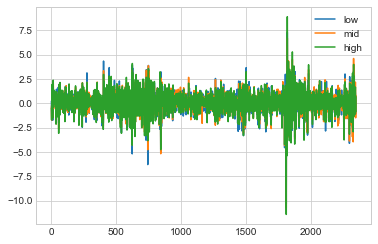

In [1046]:
plt.plot(low_p, label = 'low')
plt.plot(mid_p, label = 'mid')
plt.plot(high_p, label = 'high')
plt.legend();

In [1047]:
rt['port_low'] = low_p
rt['port_mid'] = mid_p
rt['port_high'] = high_p

In [1048]:
rt.to_excel('rt.xlsx')
ff.to_excel('ff.xlsx')
esg_esg.to_excel('esg_esg.xlsx')

In [1049]:
test = rt.copy()
test = test.replace(0, np.nan)
test.dropna(how='all', axis='index', thresh=4, inplace=True)
test = test.replace(np.nan, 0)
tab = test.describe()

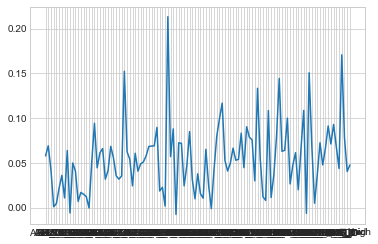

In [1050]:
plt.plot(tab.loc['mean',:]);

In [1054]:
high_r = tab.loc['mean',:].sort_values(ascending=False).tolist()
tab.loc['mean',:].sort_values(ascending=False).head()

EVO_S      0.21323
VWS_D      0.17069
SRT3_G     0.15236
GMAB_D     0.15066
AMBUB_D    0.14433
Name: mean, dtype: float64

In [1055]:
esg_high_r = esg_esg.loc[:,['EVO_S','VWS_D','SRT3_G','GMAB_D','AMBUB_D','SALM_N','BAKKA_N','DSV_D','TOM_N','BAVA_D' ]].mean().tolist()

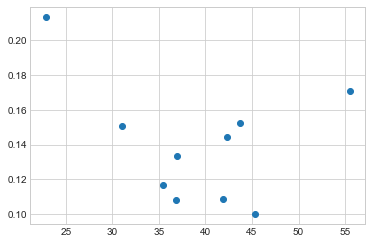

In [1057]:
plt.scatter(esg_high_r,high_r[:10]);

In [ ]:
high_l = tab.loc['mean',:].sort_values(ascending=True).tolist()
high_l=high_l[:10]
high_l

In [ ]:
esg_high_l = esg_esg.loc[:,['HMB_S','FLS_D','DBK_G','TELIA_S','HEN3_G','BAS_G','ESSITYB_S','BAYN_G','ISS_D','EOAN_G' ]].mean().tolist()
esg_high_l

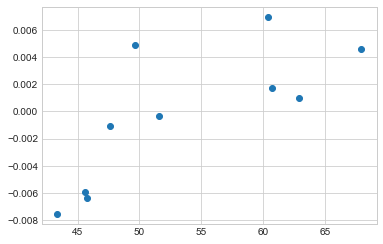

In [1058]:
plt.scatter(esg_high_l,high_l);

In [1067]:
rtt_test.tail(20)

,date,ADS_G,AIR_G,ALV_G,BAS_G,BAYN_G,BMW_G,BNR_G,CON_G,DB1_G,DBK_G,DPW_G,DTE_G,EOAN_G,FME_G,FRE_G,HEI_G,HEN3_G,HNR1_G,IFX_G,MBG_G,MRK_G,MTX_G,MUV2_G,PAH3_G,PUM_G,QIA_G,RWE_G,SAP_G,SIE_G,SRT3_G,SY1_G,VNA_G,VOW3_G,ZAL_G,ABB_S,ALFA_S,ALIV_S,ASSAB_S,ATCOA_S,ATCOB_S,AZN_S,BOL_S,ELUXB_S,ERICB_S,ESSITYB_S,EVO_S,GETIB_S,HEXAB_S,HMB_S,INVEB_S,KINVB_S,NDA_S,SAND_S,SCAB_S,SEBA_S,SHBA_S,SKAB_S,SKFB_S,SWEDA_S,SWMA_S,TEL2B_S,TELIA_S,VOLVB_S,AKER_N,AKRBP_N,BAKKA_N,BWLPG_N,BWO_N,DNB_N,DNO_N,ENTRA_N,EQNR_N,FRO_N,GJF_N,LSG_N,MOWI_N,NHY_N,ORK_N,SALM_N,SCHA_N,SUBC_N,TEL_N,TOM_N,TGS_N,YAR_N,STB_N,AMBUB_D,MAERSKA_D,MAERSKB_D,BAVA_D,CARLB_D,CHR_D,COLOB_D,DANSKE_D,DEMANT_D,DSV_D,FLS_D,GMAB_D,GN_D,ISS_D,LUN_D,NOVOB_D,NZYMB_D,ORSTED_D,PNDORA_D,ROCKB_D,RBREW_D,SIM_D,TRYG_D,VWS_D,m
2345,2022-03-29,2.34962,5.37934,1.7695,4.53941,1.74027,5.61094,1.03834,10.093,0.45844,2.62391,1.90265,1.37002,2.37688,-1.25123,0.6531,4.88538,2.02218,2.65252,4.44623,4.60022,5.69172,1.62059,2.94179,6.64767,3.57143,1.26582,0.73529,2.41632,4.07121,3.47761,1.62037,1.49115,5.10083,4.88926,-0.97699,3.77419,4.03315,0.77851,0.08109,0.71842,-0.66086,-8.69205,7.99588,-1.57038,4.86909,2.78,3.54533,0.71188,5.24446,2.04032,3.55821,1.91368,3.41797,-3.41857,2.54197,1.06071,3.58928,6.60823,1.78845,-1.81081,0.29165,0.02662,3.50389,-4.72488,-3.71771,1.5756,-1.08063,-0.28249,0.34247,-4.90845,-0.27778,-5.07685,-5.01206,-2.05449,0.94036,-0.94924,-6.73184,0.53165,-0.59966,5.65517,-1.47689,0.34789,4.47211,-1.62413,3.04892,1.31991,3.07118,-4.39614,-4.08451,5.82233,4.49272,1.76338,1.30826,2.39339,4.1311,-0.44944,8.13853,-0.28986,2.72005,4.45117,2.23557,1.68817,0.80447,0.02502,3.62274,4.71616,2.52541,2.44,-0.03113,1.33262,NaN
2346,2022-03-30,-0.64279,-2.23552,-1.02951,-3.17951,-0.16137,-2.86821,-2.55599,-6.63343,0.48677,-2.79078,-3.84281,-0.60067,-0.81724,0.03334,-1.31281,-4.2637,-1.91816,-0.71059,-2.91993,-2.24383,-0.8503,-1.87617,-1.01338,-1.53606,-1.334,0.24554,0.756,-1.31503,-3.3021,-1.06383,-0.82005,-0.61983,-0.26336,-1.89243,-3.34182,-1.24339,-3.61126,-0.927,-1.3571,-1.61068,0.47055,7.29828,-1.71592,1.9448,-2.2777,-2.08212,0.2091,-1.41369,-2.17421,-0.73792,-0.33764,-0.72913,-3.68272,1.17057,-2.058,-1.18356,-6.31579,-2.27704,0.251,-0.05505,1.59942,0.2661,-3.44976,3.89203,6.44634,1.48515,1.34454,3.11615,-0.63384,6.43179,-0.27855,6.85312,6.57449,1.68719,2.05933,1.25,5.52644,-0.85621,1.80982,-4.43864,0.77369,-0.38521,-0.08826,2.08333,1.36896,-0.72864,2.27502,0.30318,0.24474,1.27623,0.33073,-1.04775,1.64447,-0.17,-0.68852,-0.30098,-2.53536,2.99003,-1.0116,-0.86885,0.91384,1.99757,1.52959,2.8014,-1.08499,-3.54462,-0.93121,-1.4057,1.83743,5.68122,NaN
2347,2022-03-31,-2.07948,-0.75621,0.11558,-2.87108,0.37175,-2.06828,-0.83829,-2.99614,-1.30185,-1.06584,-1.67081,-1.61534,-1.29213,1.26667,1.97248,-3.33084,-1.10821,0.4229,-1.89964,-2.35654,-1.32536,0.71702,-0.4914,-0.63305,-1.22449,-0.84614,2.27684,-0.92103,-3.35333,-1.83284,0.0,-2.2638,-1.29511,-6.59898,0.65854,2.39219,-0.60606,-0.62378,0.96509,0.44434,0.85594,0.99282,-7.46848,-1.4165,-0.40341,-3.80564,-1.66927,0.18868,-12.90723,-1.1271,-1.35512,-2.10283,-1.47059,1.07438,-2.149,-1.80791,-1.02996,-0.35599,-11.74261,-2.39603,1.82469,0.15924,-1.71416,-2.1148,1.62927,-3.57724,0.24876,0.27473,-1.81551,-0.19246,-1.28492,1.39293,2.14456,-1.92825,-2.57026,-2.05761,-2.82167,-0.4826,-1.46727,-0.68306,-1.12764,-1.97216,-0.33127,1.34771,-3.72468,-1.8016,-1.5748,0.50378,-0.53711,-4.03248,-2.28397,1.1403,1.68734,-4.12942,1.02344,-1.84906,-2.79299,-0.60484,0.0,0.87646,0.67917,-0.89983,1.0917,3.309,-1.34065,-3.50195,-4.12371,-1.58416,0.45872,-0.57242,NaN
2348,2022-04-01,-0.11798,0.45356,1.15447,1.68083,1.0467,1.27226,-1.17262,2.47706,1.19632,3.78801,-1.58439,0.7914,-0.35098,0.09875,-0.76473,1.74216,0.13184,0.0,0.22592,0.92462,-1.29049,-0.56953,-0.0823,0.84187,-0.59401,-0.22457,0.10119,-0.71203,0.38198,-1.39408,-0.32154,1.55991,1.49045,3.84783,0.62152,0.6763,1.10865,0.11769,0.4881,0.97788,-1.76141,0.20916,0.04193,1.54114,2.61026,1.84898,-0.23873,0.79096,2.31415,0.43658,0